In [1]:
import pandas as pd 
import os
from config import * 
import matplotlib.pyplot as plt 
import datetime
import numpy as np 

directory = os.fsencode('popularity_export')

In [2]:


def merge_rh_vol_w_barset(security,calc_profit = True,trend_window = 4,vol_thresh = 0):
    rh_vol = pd.read_csv('popularity_export/{}.csv'.format(security))
    rh_vol.index = pd.to_datetime(rh_vol['timestamp']).dt.date
    rh_vol.drop_duplicates(inplace=True,keep = 'first')
    rh_vol.drop('timestamp',axis =1,inplace=True)
    bars = api.polygon.historic_agg_v2(security,1,'day',_from= rh_vol.index[0],to=datetime.date.today()).df
    latest = api.polygon.historic_agg_v2(security,1,'minute',_from= datetime.date.today() - datetime.timedelta(days=5),to=datetime.date.today()).df.iloc[-1]
    bars = bars.append(latest)
    bars.iloc[-1]['volume'] = np.NaN
    bars.index = bars.index.date
    merged = bars.join(rh_vol.groupby('timestamp').max()['users_holding'])
    merged['rh_vol_pct'] = merged['users_holding']*100/merged['volume']
    merged['rh_action'] = merged['users_holding'].copy()*0
    rh_trend_up = ((merged['users_holding'] > merged['users_holding'].shift(1)).rolling(trend_window).sum() == trend_window)
    price_trend_down = ((merged['open'] < merged['open'].shift(1)).rolling(trend_window).sum() == trend_window)
    is_vol_significant = merged['rh_vol_pct'].shift(1) > vol_thresh
    merged['rh_action'][rh_trend_up & price_trend_down & is_vol_significant] = 1
    if calc_profit:
        merged['profit'] = merged['users_holding'].copy()*0
        merged['profit'][merged['rh_action'] == 1] = (merged['close'].shift(-trend_window) - merged['open'])/merged['open'] 
    #print('{} traded {} times, total_profit_pct: {}'.format(security,len(merged[merged['rh_action'] == 1]),merged[merged['rh_action'] == 1]['profit'].sum()))
    return merged

def normalize_merged(schema,df):
    blank_df = pd.DataFrame(0, index=schema.index, columns=list(schema))
    blank_df.update(df)
    return blank_df

# asset = merge_rh_vol_w_barset('AMD')
# print(asset[asset['rh_action'] != 0])
# print(asset[asset['rh_action'] == 1]['profit'].sum())
# fig,ax = plt.subplots()
# ax.plot(asset['close'],color ='red')
# ax2 = ax.twinx()
# ax2.plot(asset['users_holding'])
# plt.show()


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


CSCO traded, net: 0.031516674059347216, num trades: 4
PRI traded, net: 0.42841496396903506, num trades: 2
SLIM data not found
BIOS data not found
NZF traded, net: 0.005590496156533897, num trades: 1
CSUAY data not found
MQBKY data not found
UNT data not found
SPXB traded, net: 0.003497383956800313, num trades: 1
HUBS traded, net: 0.03655040182888356, num trades: 1
PSM data not found
ZURVY data not found
SBGI traded, net: 0.637722026495926, num trades: 4
PWCDF data not found
SITC traded, net: 0.8747149753895991, num trades: 2
PPA traded, net: 0.01298274445357435, num trades: 1
XOXO data not found
CARO data not found
AEIS traded, net: 0.056307631940357164, num trades: 1
UAL traded, net: 0.1257326159810278, num trades: 5
TROW traded, net: 0.12494861738303381, num trades: 3
ISRG traded, net: 0.10428934871541919, num trades: 3
QDIV traded, net: 0.08151041666666674, num trades: 1
EFC traded, net: 1.7368251084872337, num trades: 2


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EEX traded, net: 0.37585424440077086, num trades: 3


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


NVR traded, net: 0.763067183972684, num trades: 4
TLRY traded, net: 1.2312246917342429, num trades: 3
LECO traded, net: 0.01121904501299758, num trades: 1


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ALTG traded, net: 0.2713479982466496, num trades: 3
RPT traded, net: 0.14342629482071728, num trades: 1
VCYT traded, net: 0.04070959963935744, num trades: 1
OIIL data not found


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


PLOW traded, net: 0.23097014925373138, num trades: 1


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BUD traded, net: 0.0979575417967595, num trades: 8
HVT.A data not found
GDI data not found
PDS traded, net: 0.08399789189733134, num trades: 2
BLDP traded, net: 0.13941690120516706, num trades: 2
NOG traded, net: 1.597099536680619, num trades: 6
SWGAY data not found
BXC traded, net: 0.8679147812843748, num trades: 3
SMCAY data not found
TTNDY data not found
             returns  num_assets_traded   cum_returns
2018-05-02  1.000000                0.0  1.000000e+00
2018-05-03  1.000000                0.0  1.000000e+00
2018-05-04  1.000000                0.0  1.000000e+00
2018-05-07  1.000000                0.0  1.000000e+00
2018-05-08  1.000000                0.0  1.000000e+00
...              ...                ...           ...
2020-06-03  1.592105                1.0  7.953707e-11
2020-06-04  1.000000                0.0  7.953707e-11
2020-06-05  1.000000                0.0  7.953707e-11
2020-06-08  1.000000                0.0  7.953707e-11
2020-06-09  1.000000                0.0  7.953

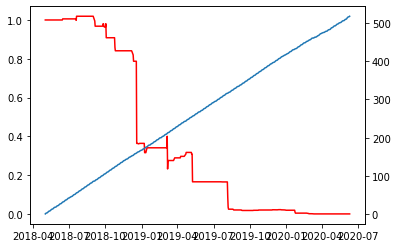

In [7]:


def robintrack_strat(limit=100):    
    asset_data = {}
    standard = merge_rh_vol_w_barset('AMZN') # standard barset schema
    returns = pd.DataFrame(1, index=standard.index, columns=['returns','num_assets_traded']) 
    returns['num_assets_traded'] -= 1 
    for filename in os.listdir(directory)[:limit]:
        security = os.fsdecode(filename).replace('.csv','')
        try:
            asset_returns = normalize_merged(standard,merge_rh_vol_w_barset(security))
        except: 
            print('{} data not found'.format(security))
            continue
        returns['returns'] += asset_returns['profit']
        returns['num_assets_traded'] += asset_returns['rh_action']
        if asset_returns['profit'].sum() > 0: 
            print('{} traded, net: {}, num trades: {}'.format(security,asset_returns['profit'].sum(),len(asset_returns[asset_returns['profit'] > 0])))
            
    returns['returns'][returns['num_assets_traded'] > 0] /= returns[returns['num_assets_traded'] > 0]['num_assets_traded']
    returns['cum_returns'] = returns['returns'].cumprod()
    return returns

res = robintrack_strat()
fig,ax = plt.subplots()
ax.plot(res['cum_returns'],color ='red')
ax2 = ax.twinx()
ax2.plot(res['returns'].cumsum())
print(res)
print('cumulative return: {}%, APR: {}%, max_drawdown (approx): {}%, total trades: {}'.format((res['cum_returns'].iloc[-1]-1)*100,(np.sqrt(res['cum_returns'].iloc[-1])-1)*100,(1- res['cum_returns'].min())*100,res['num_assets_traded'].sum()))
plt.show()


154.0


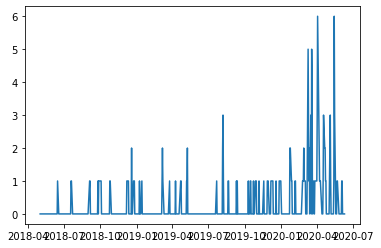

In [4]:
plt.plot(res['num_assets_traded'])
print(res['num_assets_traded'].sum())

In [3]:
for filename in os.listdir(directory):
    security = os.fsdecode(filename).replace('.csv','')
    try:
        asset_returns = merge_rh_vol_w_barset(security)
        if asset_returns['rh_action'].iloc[-1] == 1:
            print('{} recommendation '.format(security))
            print(asset_returns.iloc[-1])
    except: 
        print('{} data not found'.format(security))
print('done')
        

/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


SLIM data not found
BIOS data not found
CSUAY data not found
MQBKY data not found
UNT data not found


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ZURVY data not found
PWCDF data not found
XOXO data not found
CARO data not found
OIIL data not found
GDI data not found
SWGAY data not found
SMCAY data not found
TTNDY data not found
RMGN data not found
OVCHY data not found
CSS data not found
ESGF data not found
BFRA data not found
AVHI data not found
AGC data not found
GVDNY data not found
VQT data not found
TIG data not found
STLC data not found
JNP data not found
OCPNY data not found
EJPRY data not found
PMPT data not found
FTR data not found
EACQ data not found
BSJI data not found
SVU data not found
WBC data not found
WCG data not found
FIEU data not found
WBAL data not found
WLH data not found
PBBI data not found
SKYAY data not found
ZBIO data not found
TROV data not found
DNZOY data not found
BPMX data not found
BKRKY data not found
CORV data not found
GHII data not found
TUES data not found
SGSOY data not found
MTGE data not found
SRAC data not found
EIO data not found
LGCY data not found
KBCSY data not found
CLPHY data not fou

MAURY data not found
STPP data not found
RTMVY data not found
CBPX data not found
ADRD data not found
MITSY data not found
FRN data not found
DSDVY data not found
GNBC data not found
CCT data not found
JJE data not found
TSLF data not found
WDRW data not found
GBUG data not found
KCDMY data not found
DMLRY data not found
QBIEY data not found
TRYIY data not found
WAAS data not found
AOBC data not found
NSANY data not found
CNDF data not found
ESCR data not found
CUO data not found
PDEV data not found
SPHS data not found
VWAGY data not found
DSEEY data not found
GFASY data not found
EVSTC data not found
FLSA data not found
KYE data not found
GSAH data not found
BRPM data not found
BAESY data not found
RBZ data not found
BWMC data not found
RBGLY data not found
SLLDY data not found
NVZMY data not found
FLIO data not found
DCMYY data not found
HENOY data not found
WIL data not found
EVP data not found
PBEE data not found
FINZ data not found
DTUS data not found
ANDV data not found
FKO data 

In [4]:
asset = merge_rh_vol_w_barset('MDB')
print(asset)
print(asset[asset['rh_action'] == 1])

              open      high       low     close     volume  users_holding  \
2018-05-02   36.71   37.7200   36.3493   37.1100   433548.0         2184.0   
2018-05-03   37.25   38.9000   36.8261   38.5500  1452662.0         2193.0   
2018-05-04   38.61   39.3500   36.3000   36.9700  1249174.0         2211.0   
2018-05-07   37.00   37.9800   36.8601   37.7600   562777.0         2216.0   
2018-05-08   37.95   41.0100   37.7900   41.0100  2732023.0         2216.0   
...            ...       ...       ...       ...        ...            ...   
2020-06-05  201.14  208.9000  190.9200  197.9800  3236130.0         9375.0   
2020-06-08  198.08  205.5800  192.6600  203.8800  1675716.0         9538.0   
2020-06-09  200.45  207.0400  199.6500  201.7000   864366.0         9640.0   
2020-06-10  204.61  210.9800  202.0000  208.1800   975331.0         9640.0   
2020-06-11  198.69  198.7099  198.1436  198.2517        NaN            NaN   

            rh_vol_pct  rh_action  profit  
2018-05-02    0.503

In [ ]:
api.polygon.historic_agg_v2('PSM',1,'minute',_from= datetime.date.today() - datetime.timedelta(days=5),to=datetime.date.today()).df
print(api.polygon.last_quote('PSM'))